# Anomaly detection
## IsolationForest implementation
To detect anomalies 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pathlib import Path

DATA_PATH = Path("../data")

primary = pd.read_csv(DATA_PATH/"primary_cohort.csv")
study = pd.read_csv(DATA_PATH/"study_cohort.csv")
validation = pd.read_csv(DATA_PATH/"validation_cohort.csv")
df = pd.concat([primary, study, validation], ignore_index=True)

features = [
    'age_years',
    'episode_number'
]

X = df[features]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Hyperparameter tuning
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    max_samples= 'auto',
    max_features=1.0,
    random_state=42,
    n_jobs=-1
)

df['anomaly'] = iso_forest.fit_predict(X_scaled)

# quick verification
df['anomaly'].value_counts()


anomaly
 1    2671
-1     134
Name: count, dtype: int64

## Testing multiple hyperparameters
Indicates the number of anomalies detected

In [3]:
from itertools import combinations
param_grid = [
    {"contamination": 0.02, "max_samples": 128, "n_estimators": 200},
    {"contamination": 0.02, "max_samples": 256, "n_estimators": 200},
    {"contamination": 0.05, "max_samples": 128, "n_estimators": 200},
    {"contamination": 0.05, "max_samples": 256, "n_estimators": 200},
    {"contamination": 0.08, "max_samples": 256, "n_estimators": 300},
]

results= {}

# line comparaison
for params in param_grid:
    iso = IsolationForest(random_state=42, **params)
    labels = iso.fit_predict(X_scaled)
    results[str(params)] = set(df.index[labels == -1])
    #print(f"contamination={params} → number of anomalies={(labels == -1).sum()}")

# measure stability
for (p1, a1), (p2, a2) in combinations(results.items(), 2):
    jaccard = len(a1 & a2) / len(a1 | a2)
    print(f"{p1} vs {p2} → Jaccard = {jaccard:.2f}")


{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} → Jaccard = 0.66
{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 128, 'n_estimators': 200} → Jaccard = 0.37
{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 256, 'n_estimators': 200} → Jaccard = 0.36
{'contamination': 0.02, 'max_samples': 128, 'n_estimators': 200} vs {'contamination': 0.08, 'max_samples': 256, 'n_estimators': 300} → Jaccard = 0.23
{'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 128, 'n_estimators': 200} → Jaccard = 0.28
{'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} vs {'contamination': 0.05, 'max_samples': 256, 'n_estimators': 200} → Jaccard = 0.39
{'contamination': 0.02, 'max_samples': 256, 'n_estimators': 200} vs {'contamination': 0.08, 'max_sam

## Anomalies visualisation
identify major anomalies

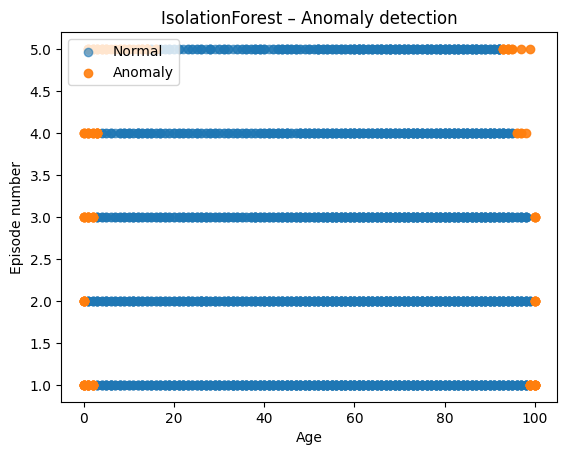

In [4]:
import matplotlib.pyplot as plt

plt.scatter(
    df.loc[df['anomaly'] == 1, 'age_years'],
    df.loc[df['anomaly'] == 1, 'episode_number'],
    label='Normal',
    alpha=0.6
)

plt.scatter(
    df.loc[df['anomaly'] == -1, 'age_years'],
    df.loc[df['anomaly'] == -1, 'episode_number'],
    label='Anomaly',
    alpha=0.9
)

plt.xlabel("Age")
plt.ylabel("Episode number")
plt.title("IsolationForest – Anomaly detection")
plt.legend()
plt.show()


### Score distribution visualistion

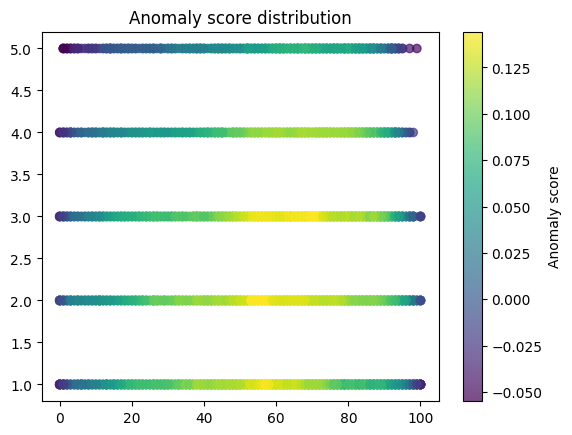

In [20]:
df['score'] = iso_forest.decision_function(X_scaled)

df['score'].describe()
df.loc[df['score'] < 0].head()

plt.scatter(
    df['age_years'],
    df['episode_number'],
    c=df['score'],
    alpha=0.7
)
plt.colorbar(label="Anomaly score")
plt.title("Anomaly score distribution")
plt.show()

custom_threshold = -0.02
df['custom_anomaly'] = (df['score'] < custom_threshold).astype(int)



## Compare with simple alternative
To find the threshold, I use the variable ‘age_years’, as it is a continuous variable, Gaussian distribution, and possible extreme values.

In [11]:
upper_limit = df['age_years'].mean() + 3*df['age_years'].std()
lower_limit = df['age_years'].mean() - 3*df['age_years'].std()
print('upper limit',upper_limit)
print('lower limit',lower_limit)

upper limit 137.57045704853158
lower limit -25.53052834977934


In [ ]:
# Split train / test
from sklearn.model_selection import train_test_split

x = df[['age_years', 'sex_0male_1female', 'episode_number']]
y = df['hospital_outcome_1alive_0dead']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### outliers diagnostic using Z-score

In [15]:
mean_age = X_train['age_years'].mean()
std_age = X_train['age_years'].std()

z_scores = (X_train['age_years'] - mean_age) / std_age
z_outliers_train = z_scores.abs() > 3

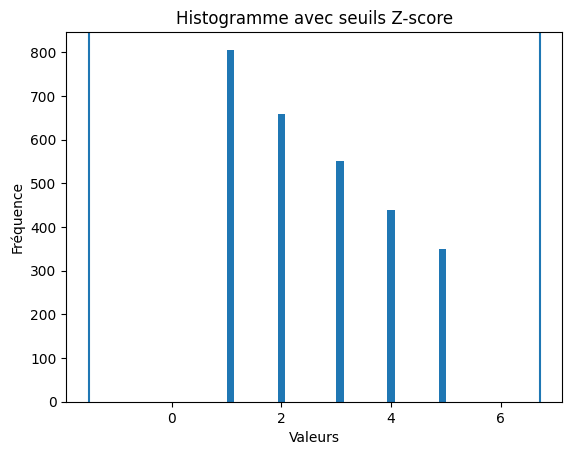

In [ ]:
# Histogram

import matplotlib.pyplot as plt
from scipy.stats import zscore


# Z-score
z = zscore(x)

# Seuil
threshold = 3

#  Mean and standard deviation
mu = x.mean()
sigma = x.std()

# Plot
plt.figure()
plt.hist(x, bins=30)
plt.axvline(mu + threshold * sigma)
plt.axvline(mu - threshold * sigma)
plt.title("Histogramme avec seuils Z-score")
plt.xlabel("Valeurs")
plt.ylabel("Fréquence")
plt.show()


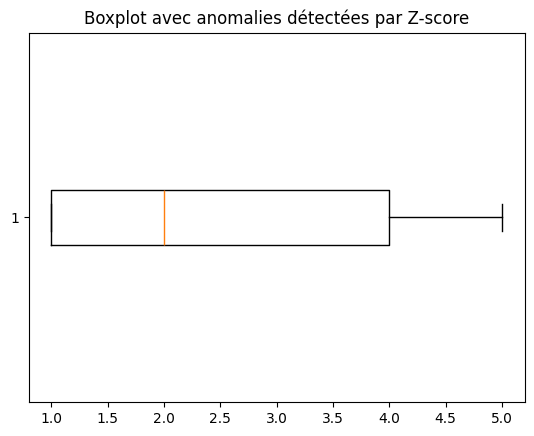

In [17]:
# boxplot anomalies with zscore
anomalies = x[np.abs(z) > threshold]

plt.figure()
plt.boxplot(x, vert=False)
plt.scatter(anomalies, np.ones(len(anomalies)))
plt.title("Boxplot avec anomalies détectées par Z-score")
plt.show()


### Anomaly outlier IQR

In [ ]:
Q1 = X_train['age_years'].quantile(0.25)
Q3 = X_train['age_years'].quantile(0.75)
IQR = Q3 - Q1

lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR

# outlier detection 
iqr_outliers_train = (
    (X_train['age_years'] < lower_iqr) |
    (X_train['age_years'] > upper_iqr)
)


1423    False
898     False
580     False
2463    False
269     False
        ...  
2214    False
786     False
1647    False
963     False
763     False
Name: age_years, Length: 2244, dtype: bool


### Treatment to use
For this type of dataset, it would be advisable to use winsorization rather than deletion.
This allows us to retain patients who may be rare and avoid further bias.


In [22]:
X_train['age_years'] = X_train['age_years'].clip(
    lower=lower_iqr,
    upper=upper_iqr
)

X_test['age_years'] = X_test['age_years'].clip(
    lower=lower_iqr,
    upper=upper_iqr
)

# Using IQR

Q1_e = X_train['episode_number'].quantile(0.25)
Q3_e = X_train['episode_number'].quantile(0.75)
IQR_e = Q3_e - Q1_e

lower_e = Q1_e - 1.5 * IQR_e
upper_e = Q3_e + 1.5 * IQR_e

X_train['episode_number'] = X_train['episode_number'].clip(lower_e, upper_e)
X_test['episode_number'] = X_test['episode_number'].clip(lower_e, upper_e)
